<a href="https://colab.research.google.com/github/negiamishhu/Skin-disease-detection-using-CNN/blob/main/Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: gdrive mount code

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing required libraries
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(seed)
tensorflow.random.set_seed(101)

import tensorflow
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.layers import GlobalAveragePooling2D
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = '/content/drive/MyDrive/aug_dir1'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('/content/drive/MyDrive/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('/content/drive/MyDrive/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '/content/drive/MyDrive/base_dir/train_dir/' + img_class


    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders

    ###########

    num_aug_images_wanted = 6000 # total number of images we want to have in each class

    ###########

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('/content/drive/MyDrive/aug_dir1')

Found 5920 images belonging to 1 classes.
Found 5920 images belonging to 1 classes.
Found 5858 images belonging to 1 classes.
Found 5217 images belonging to 1 classes.
Found 5290 images belonging to 1 classes.
Found 4410 images belonging to 1 classes.


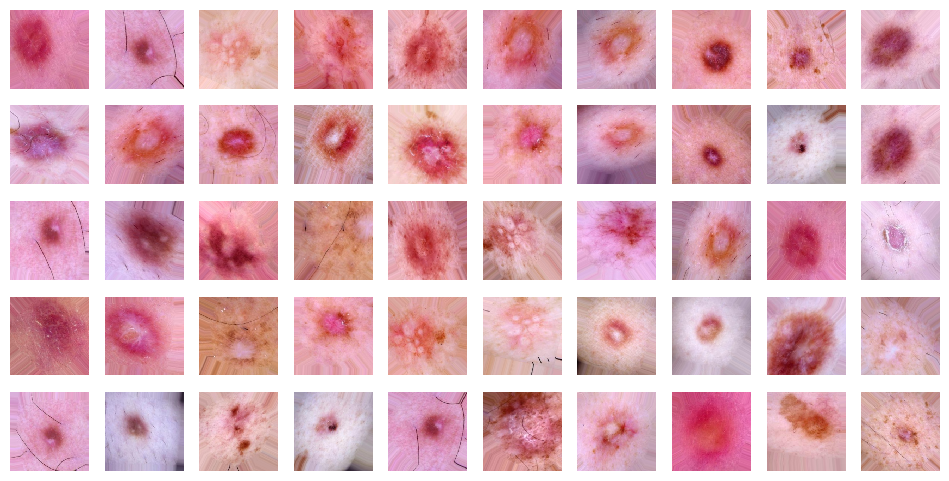

In [ ]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=None) # titles=labels will display the image labels

In [ ]:
df_data = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')

# here we identify lesion_id's that have duplicate images and those that have only
# one image.
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)
def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)
df_data['duplicates'].value_counts()
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape
# identify train and val rows
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape
# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']

# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

df_train['dx'].value_counts()
df_val['dx'].value_counts()

9077
938


dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [ ]:
train_path = '/content/drive/MyDrive/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 42069 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [ ]:
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)


# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model=Model(inputs=mobile.input,outputs=predictions)

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [ ]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

<ipython-input-24-649a607b18e1>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,


Epoch 1/30
908/908 [==============================] - ETA: 0s - loss: 1.6661 - categorical_accuracy: 0.5371 - top_2_accuracy: 0.7335 - top_3_accuracy: 0.8539
Epoch 1: val_top_3_accuracy improved from -inf to 0.96802, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


908/908 [==============================] - 1044s 1s/step - loss: 1.6661 - categorical_accuracy: 0.5371 - top_2_accuracy: 0.7335 - top_3_accuracy: 0.8539 - val_loss: 0.6266 - val_categorical_accuracy: 0.8017 - val_top_2_accuracy: 0.9200 - val_top_3_accuracy: 0.9680 - lr: 0.0100
Epoch 2/30
908/908 [==============================] - ETA: 0s - loss: 1.1639 - categorical_accuracy: 0.6419 - top_2_accuracy: 0.8228 - top_3_accuracy: 0.9204
Epoch 2: val_top_3_accuracy did not improve from 0.96802
908/908 [==============================] - 670s 738ms/step - loss: 1.1639 - categorical_accuracy: 0.6419 - top_2_accuracy: 0.8228 - top_3_accuracy: 0.9204 - val_loss: 0.4670 - val_categorical_accuracy: 0.8582 - val_top_2_accuracy: 0.9339 - val_top_3_accuracy: 0.9659 - lr: 0.0100
Epoch 3/30
908/908 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.6779 - top_2_accuracy: 0.8532 - top_3_accuracy: 0.9398
Epoch 3: val_top_3_accuracy did not improve from 0.96802

Epoch 3: Re

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import shutil
from tensorflow.keras.models import load_model, save_model
# saving and loading the .h5 model

# save model
model.save('\content\drive\MyDrive\model.h5')
print('Model Saved!')
model.save('model.h5')
print('Model Saved!')
 # save model
model.save_weights('MobNET_ModelWeights')
print('Model Saved!')

# load model
savedModel = model.load_weights('MobNET_ModelWeights')
print('Model Loaded!')
# load model
savedModel=load_model('model.h5')
savedModel.summary()
# saving and loading the model weights



NameError: name 'model' is not defined

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5', save_format='h5')

NameError: name 'model' is not defined

In [ ]:
# get the metric names so we can use evaulate_generator
print(model.metrics_names)
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']


<ipython-input-31-404cbfb67041>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.34868064522743225
val_cat_acc: 0.8944562673568726
val_top_2_acc: 0.9658848643302917
val_top_3_acc: 0.9914712309837341


In [ ]:
# Get the labels of the test images.

test_labels = test_batches.classes
print(test_labels)
print(test_batches.class_indices)
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)
print(predictions.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

<ipython-input-32-c348e061a1c7>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)


938/938 [==============================] - 55s 58ms/step
(938, 7)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(938,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 15   2   5   0   3   1   0]
 [  1  24   2   0   1   2   0]
 [  0   0  47   1  11  16   0]
 [  0   0   0   3   0   3   0]
 [  2   1   2   0  24  10   0]
 [  2   4   7   1  20 716   1]
 [  0   0   0   0   0   1  10]]


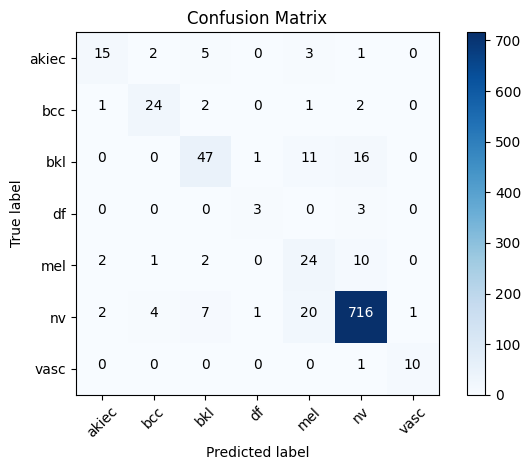

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.75      0.58      0.65        26
         bcc       0.77      0.80      0.79        30
         bkl       0.75      0.63      0.68        75
          df       0.60      0.50      0.55         6
         mel       0.41      0.62      0.49        39
          nv       0.96      0.95      0.95       751
        vasc       0.91      0.91      0.91        11

    accuracy                           0.89       938
   macro avg       0.73      0.71      0.72       938
weighted avg       0.90      0.89      0.90       938



In [ ]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

<ipython-input-41-fe056fefdc1b>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.34868064522743225
val_cat_acc: 0.8944562673568726
val_top_2_acc: 0.9658848643302917
val_top_3_acc: 0.9914712309837341


In [ ]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

<ipython-input-42-257134288b2d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)


938/938 [==============================] - 62s 66ms/step


Confusion matrix, without normalization
[[ 15   2   5   0   3   1   0]
 [  1  24   2   0   1   2   0]
 [  0   0  47   1  11  16   0]
 [  0   0   0   3   0   3   0]
 [  2   1   2   0  24  10   0]
 [  2   4   7   1  20 716   1]
 [  0   0   0   0   0   1  10]]


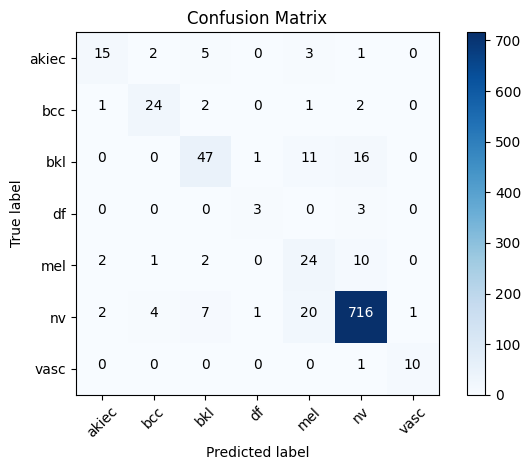

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.75      0.58      0.65        26
         bcc       0.77      0.80      0.79        30
         bkl       0.75      0.63      0.68        75
          df       0.60      0.50      0.55         6
         mel       0.41      0.62      0.49        39
          nv       0.96      0.95      0.95       751
        vasc       0.91      0.91      0.91        11

    accuracy                           0.89       938
   macro avg       0.73      0.71      0.72       938
weighted avg       0.90      0.89      0.90       938



In [ ]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk
